In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [0]:
!unzip glasses.zip

In [74]:
image_size = 64
if torch.cuda.is_available(): device = 'cuda'
else: device = 'cpu'
# device = 'cpu'
train_path = '/content/glasses/train'
test_path = '/content/glasses/test'
num_classes = 2
device

'cuda'

tensor([1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
        1, 1, 0, 1, 1, 0, 0, 1])
tensor([0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0,
        1, 0, 1, 1, 1, 0, 0, 0])
tensor([0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 0, 1, 1, 0, 1])
tensor([0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1,
        0, 0, 1, 0, 1, 1, 0, 0])
tensor([0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0,
        1, 0, 1, 0, 1, 0, 0, 1])
tensor([1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1,
        0, 0, 0, 1, 0, 0, 0, 1])
tensor([0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
        0, 1, 1, 1, 0, 1, 1, 0])
tensor([0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
        1, 0, 1, 1, 1, 1, 1, 1])
tensor([1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
        1, 0, 1,

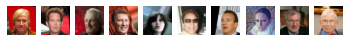

In [75]:
def load_dataset(path):
    data_path = path
    train_dataset = dset.ImageFolder(
        root=data_path,
        transform=transforms.Compose([
          transforms.Resize(image_size),
          transforms.CenterCrop(image_size),
          transforms.ToTensor()                                      
        ]),
        # target_transform = lambda x: x-1
    )
    # train_dataset.class_to_idx['0'] = 0
    # train_dataset.class_to_idx['1'] = 1
    # print(train_dataset.class_to_idx)
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=32,
        num_workers=0,
        shuffle=True
    )
    # print(train_loader.class_to_idx)
    return train_loader


for i, (x, y) in enumerate(load_dataset(train_path)):
    if i == 10:
        break
    _image = np.array(x[0])
    image = torch.from_numpy(_image)
    image = image.permute(1,2,0)
    plt.subplot(1, 10, i+1)
    plt.grid(False)
    plt.imshow(image)
    plt.axis('off')
    print(y)

In [0]:
def compute_accuracy(model, loader):
    model.eval() 
    correct = 0
    total = 0
    
    for x, y in loader:
      x_cuda = x.to(device)
      y_cuda = y.to(device)  
      pred = model(x_cuda)

      _, indices = torch.max(pred, 1)
      correct += torch.sum(indices == y_cuda)
      total += y_cuda.shape[0]  

    return float(correct)/total

def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() 
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
          
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Epoch:", epoch, "loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history


In [92]:
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

glasses_classificator = nn.Sequential(
        nn.Conv2d(3,6,5),
        nn.ReLU(),
        nn.MaxPool2d(2,2),
        nn.Conv2d(6,16,5),
        nn.ReLU(),
        nn.MaxPool2d(2,2),

        nn.Conv2d(16,32,5),
        nn.ReLU(),
        nn.MaxPool2d(2,2),

        Flattener(),

        nn.Dropout(),
        nn.Linear(512,120),
        nn.ReLU(),
        nn.Dropout(),

        nn.Linear(120,84),
        nn.ReLU(),
        nn.Linear(84,2)
)
glasses_classificator.type(torch.cuda.FloatTensor)
glasses_classificator.to(device)

Sequential(
  (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flattener()
  (10): Dropout(p=0.5, inplace=False)
  (11): Linear(in_features=512, out_features=120, bias=True)
  (12): ReLU()
  (13): Dropout(p=0.5, inplace=False)
  (14): Linear(in_features=120, out_features=84, bias=True)
  (15): ReLU()
  (16): Linear(in_features=84, out_features=2, bias=True)
)

In [93]:
loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.Adam(glasses_classificator.parameters(), lr=1e-4)

loss_history, train_history, val_history = train_model(glasses_classificator, load_dataset(train_path), load_dataset(test_path), loss, optimizer, 100)

Epoch: 0 loss: 0.687381, Train accuracy: 0.540892, Val accuracy: 0.520249
Epoch: 1 loss: 0.665930, Train accuracy: 0.617897, Val accuracy: 0.520249
Epoch: 2 loss: 0.646237, Train accuracy: 0.621083, Val accuracy: 0.568017
Epoch: 3 loss: 0.598597, Train accuracy: 0.672862, Val accuracy: 0.723780
Epoch: 4 loss: 0.553743, Train accuracy: 0.729156, Val accuracy: 0.680166
Epoch: 5 loss: 0.533642, Train accuracy: 0.747743, Val accuracy: 0.785047
Epoch: 6 loss: 0.508595, Train accuracy: 0.753585, Val accuracy: 0.727934
Epoch: 7 loss: 0.497484, Train accuracy: 0.768455, Val accuracy: 0.802700
Epoch: 8 loss: 0.474839, Train accuracy: 0.779607, Val accuracy: 0.805815
Epoch: 9 loss: 0.456381, Train accuracy: 0.799257, Val accuracy: 0.803738
Epoch: 10 loss: 0.446887, Train accuracy: 0.809347, Val accuracy: 0.805815
Epoch: 11 loss: 0.439535, Train accuracy: 0.806160, Val accuracy: 0.801661
Epoch: 12 loss: 0.436154, Train accuracy: 0.814126, Val accuracy: 0.815161
Epoch: 13 loss: 0.416922, Train acc

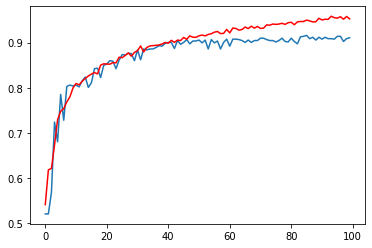

In [94]:
plt.plot(val_history)
plt.plot(train_history, color='r')
plt.show()

In [0]:
torch.save(glasses_classificator.state_dict(), '/content/dropout_conv_train_lenet_100_eph.pt')

0 0
0 0
0 0
1 1
0 0
0 0
1 1
1 1
1 1
0 0


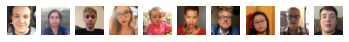

In [0]:
glasses_classificator.eval()
for i, (x, y) in enumerate(load_dataset()):
    if i == 10:
        break
    _image = np.array(x[0])
    image = torch.from_numpy(_image)
    image = image.permute(1,2,0)
    plt.subplot(1, 10, i+1)
    plt.grid(False)
    plt.imshow(image)
    plt.axis('off')
    value, indices = torch.max(glasses_classificator(x), 1)
    print(indices.item(),y.item())